In [36]:
from aleatory.processes import GBM
from aleatory.utils.utils import draw_paths
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import numpy as np

/home/cytech/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [8]:
r = 0.02
sigma = 0.15
x0 = 1.0
T = 6
N = 50
n = 20 * 6
gbm = GBM(initial=x0, drift=r, volatility=sigma, T=T)
paths = gbm.simulate(n=n, N=N)

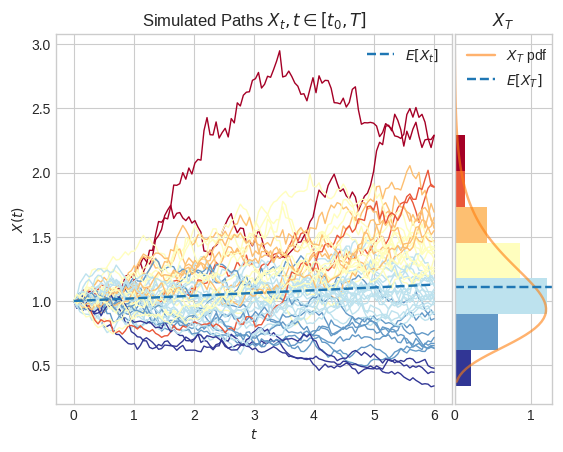

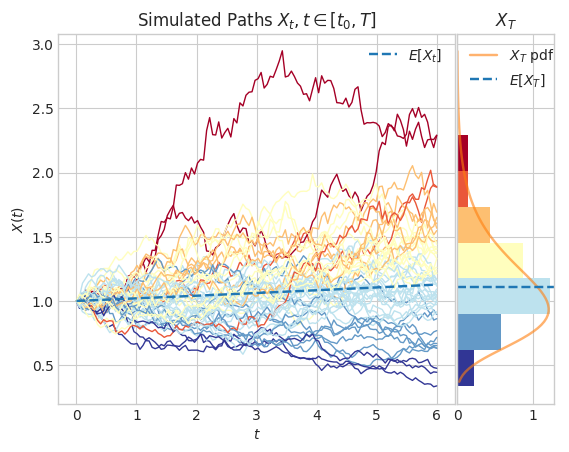

In [9]:
times = gbm.times
expectations = gbm.marginal_expectation(times)
marginalT = gbm.get_marginal(5.0)
X = np.stack(paths, axis=1)
draw_paths(
    times=times,
    paths=paths,
    N=N,
    expectations=expectations,
    marginalT=marginalT,
    marginal=True,
)

In [33]:
def variation_quadratique(t_k):
    N = 10000
    S = 0
    T = t_k
    dt = T / N
    for n in range(N):
        z = ss.norm.rvs(scale=np.sqrt(dt))
        S += np.power(z, 2)
    return S

In [34]:
x = np.linspace(0, 1, N)
L = [variation_quadratique(t) for t in x]

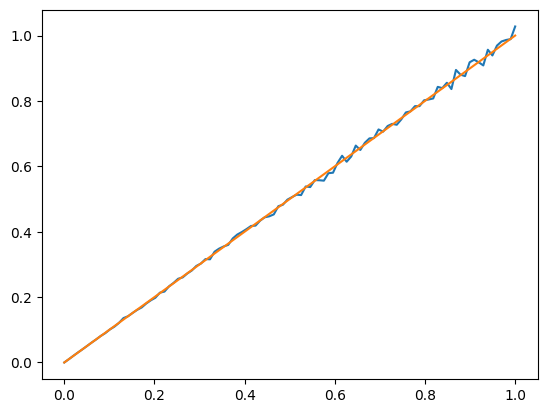

In [35]:
plt.plot(x, L)
plt.plot(x, x)

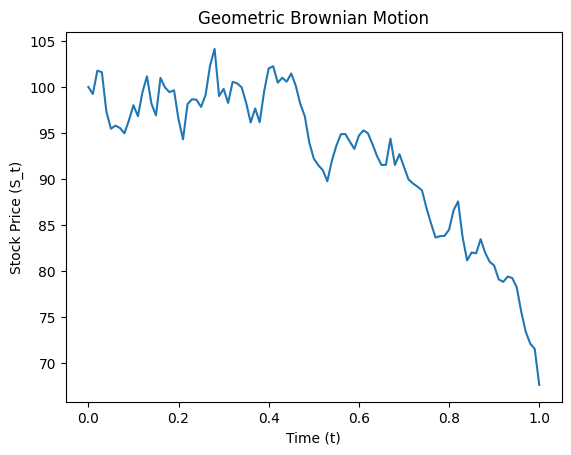

In [17]:
def geometric_brownian_motion(S0, mu, sigma, N, T, M):
    dt = T / N
    t = np.linspace(0, T, N + 1)
    dB = ss.norm.rvs(scale=np.sqrt(dt), size=(N, M))
    dB = np.vstack((np.zeros(M), dB))
    B_t = np.cumsum(dB, axis=0)
    S_t = S0 * np.exp((mu - 0.5 * sigma**2) * t[:, None] + sigma * B_t)
    return t, S_t


def option_bounds_check(call_price, strike_price, r, maturity, S0):
    """
    Check if the call option price falls within the no-arbitrage bounds.
    """
    lower_bound = strike_price * np.exp(-r * maturity)
    upper_bound = S0 - lower_bound
    if upper_bound <= call_price <= S0:
        return True
    else:
        return False


class EuropeanOptionPricing:
    def __init__(
        self,
        S0,
        strike_price,
        maturity,
        sigma: float,
        r: np.ndarray,
        dividend: bool,
        ticket: str,
        N,
    ):
        self.S0 = S0
        self.strike_price = strike_price
        self.maturity = maturity
        self.sigma = sigma
        self.r = r
        self.dividend = dividend
        self.ticket = ticket
        self.N = N

    def calibrate(self):
        """
        Calibrate the model to get the average volatility and the asset's growth rate.
        This method would typically be implemented with historical data.
        """
        pass

    def predict_volatility(self):
        """
        Predict future volatility using a model like GARCH.
        This method would typically involve fitting a GARCH model to historical data.
        """
        pass

    def hitting_time(self, scenarios):
        """
        Determine the first time the stock hits the strike price and
        the last scenarios that hit the strike price.
        """
        pass

    def price_option_call(self, S):
        """Calculate the price of a call option using the Black-Scholes model"""
        sigma = self.sigma
        r = self.r
        T = self.maturity
        K = self.strike_price
        t = np.linspace(0, T, self.N)
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))
        d2 = d1 - sigma * np.sqrt(T - t)
        return S * ss.norm.cdf(d1) - K * np.exp(-r * (T - t)) * ss.norm.cdf(d2)

    def price_option_put(self, S):
        """Calculate the price of a put option using the Black-Scholes model"""
        sigma = self.sigma
        r = self.r
        T = self.maturity
        K = self.strike_price
        t = np.linspace(0, T, self.N)
        d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * (T - t)) / (sigma * np.sqrt(T - t))
        d2 = d1 - sigma * np.sqrt(T - t)
        return K * np.exp(-r * (T - t)) * ss.norm.cdf(-d2) - S * ss.norm.cdf(-d1)

    def grecque_indices(self):
        """etude de l'impact des parametres sur le prix de l'option"""
        pass


if __name__ == "__main__":
    S0 = 100
    mu = 0.05
    sigma = 0.2
    N = 100
    T = 1
    M = 1000

    t, S_t = geometric_brownian_motion(S0, mu, sigma, N, T, M)

    plt.plot(t, S_t[:, 0])
    plt.title("Geometric Brownian Motion")
    plt.xlabel("Time (t)")
    plt.ylabel("Stock Price (S_t)")
    plt.show()


### resolution numérique de modele de black&scholes

In [18]:
def arbre_binomiaux(S0, u, d, period, M, p):
    S = np.zeros((period, M))
    S[0] = S0
    for i in range(1, period):
        q = ss.bernoulli.rvs(p, size=M)
        S[i] = q * u * S[i - 1] + (1 - q) * d * S[i - 1]
    return S

In [19]:
a = arbre_binomiaux(100, 1.1, 0)

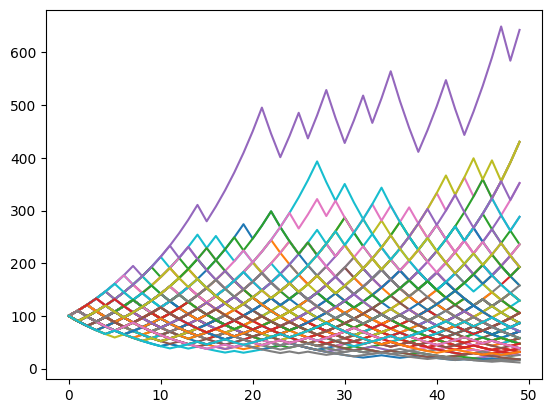

In [32]:
plt.plot(a)
plt.show()

86.4245954887943


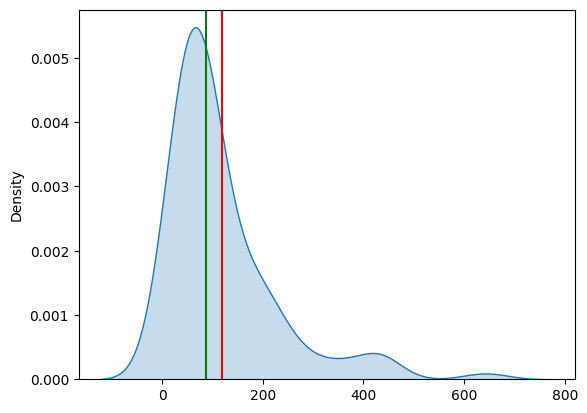

In [28]:
last_values = a[49]
sns.kdeplot(last_values, fill=True)
median = np.median(last_values)
mean = np.mean(last_values)
std = np.std(last_values, ddof=1)
plt.axvline(mean, color="red")
plt.axvline(median, color="green")
print(median)

In [140]:
from scipy.optimize import minimize, Bounds
import numpy as np

bound = Bounds(1e-10,np.inf)

class EvarAlpha:
    def __init__(self, X, alpha):
        self.X = X
        self.alpha = alpha

    def moment(self, t):
        exp = np.exp(t * self.X)
        return np.mean(exp)

    def evar_main_ft(self, t):
        return np.power(t, -1) * (np.log(self.moment(t)/self.alpha))

    def evar(self):
        result = minimize(self.evar_main_ft,x0=0.5, bounds=bound) # la fonction depend juste de t et pas de alpha 
        return result.fun
    
    def short_fall(self):
        # il fallait calculer les var pour différente quantiles et prendre la moyenne de ces var 
        pass

def x(alpha):
    return np.sqrt(-2 * np.log(alpha))

if __name__ == "__main__":

    alphas = np.linspace(0,1,100)
    L =[x(alpha) for alpha in alphas]
    L_empiric = [EvarAlpha(X,alpha).evar() for alpha in alphas]
    pass
        

### Cas D'une loi gaussian

/tmp/ipykernel_4756/2805801725.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sqrt(-2 * np.log(alpha))
/tmp/ipykernel_4756/3861878207.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  return np.power(t, -1) * (np.log(self.moment(t)/self.alpha))
/usr/local/lib/python3.10/dist-packages/scipy/optimize/_numdiff.py:590: RuntimeWarning: invalid value encountered in subtract
  df = fun(x) - f0


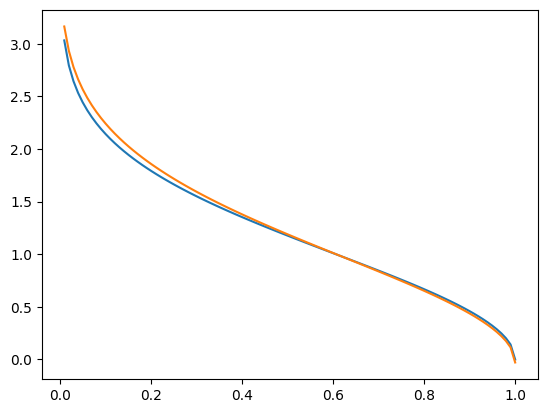

In [155]:
plt.plot(alphas,L)
plt.plot(alphas,L_empiric)
plt.show()

In [62]:
import numpy as np
import pandas as pd

nb_jours = 10
smoothing = 2

def coeff(t):
    alpha = np.array([smoothing / (1 + nb_jours)])
    if t < nb_jours:
        return np.array([])
    elif t == nb_jours:
        return np.array([1 / nb_jours] * nb_jours)
    else:
        return np.concatenate((alpha, (1 - alpha) * coeff(t - 1)))


In [240]:
path ="/home/cytech/Desktop/downloads/nasdaq.csv"

In [242]:
df=pd.read_csv(path)

In [243]:
df["Date"] = pd.to_datetime(df["Date"])
df= df.assign(Momentum = df["Close"].diff(periods=10))

/tmp/ipykernel_5005/822336313.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df["Date"] = pd.to_datetime(df["Date"])


In [244]:
df.dropna(subset="Momentum",inplace=True)

<Axes: xlabel='Date'>

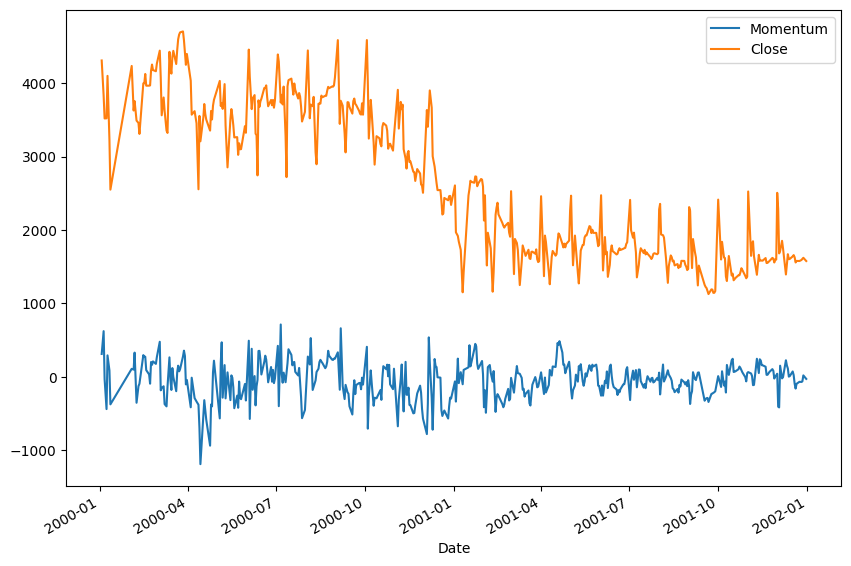

In [255]:
fig,ax = plt.subplots(figsize =(10,7))
df.plot(x ='Date',y= 'Momentum',ax=ax)
df.plot(x ='Date',y= 'Close',ax=ax)

In [249]:
df= df.assign(return_jour = np.log(df["Close"]/df["Open"])*100)
data=df["return_jour"]

In [239]:
import itertools as it
devise_pr = 'GPD'
devises = ["USD","EUR","GOLD","JPY","CHF",'GPD']
devises.remove(devise_pr)
for k in range(len(devises)):
    a=it.combinations(devises, k)
    list(a)

<Axes: xlabel='return_jour', ylabel='Density'>

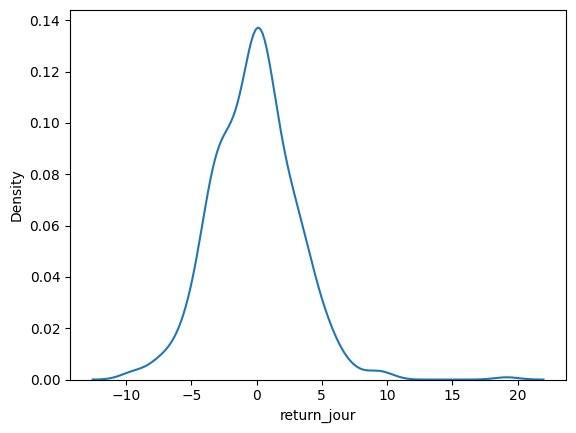

In [252]:
sns.kdeplot(data)